# Capstone Project – The Battle of Neighborhoods | Finding a Better Place in Scarborough, Toronto

### Lets import some libraies first.

In [2]:
import numpy as np 

import pandas as pd 

!pip install geocoder
import geocoder

import json 

!pip install geopy 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors



from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')

     |████████████████████████████████| 102kB 6.8MB/s ta 0:00:011
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------

### Scrape the Wikipedia page¶


In [3]:
import requests

In [4]:
from bs4 import BeautifulSoup

In [5]:
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(page.content, 'html.parser')

In [6]:
table = soup.find('tbody')
rows = table.select('tr')
row = [r.get_text() for r in rows]

### Create & clean the dataframe

In [7]:
df = pd.DataFrame(row)
df1 = df[0].str.split('\n', expand=True)
df2 = df1.rename(columns=df1.iloc[0])
df3 = df2.drop(df2.index[0])
df3.head()

,,Postal Code,,Borough,,Neighbourhood,
1,,M1A,,Not assigned,,Not assigned,
2,,M2A,,Not assigned,,Not assigned,
3,,M3A,,North York,,Parkwoods,
4,,M4A,,North York,,Victoria Village,
5,,M5A,,Downtown Toronto,,"Regent Park, Harbourfront",


### Ignore cells with a borough that is Not assigned

In [8]:
df4 = df3[df3.Borough != 'Not assigned']
df4.head()

,,Postal Code,,Borough,,Neighbourhood,
3,,M3A,,North York,,Parkwoods,
4,,M4A,,North York,,Victoria Village,
5,,M5A,,Downtown Toronto,,"Regent Park, Harbourfront",
6,,M6A,,North York,,"Lawrence Manor, Lawrence Heights",
7,,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government",


### Combine neighborhoods which have the same postal code¶


In [9]:
df5 = df4.groupby(['Postal Code', 'Borough'], sort = False).agg(','.join)
df5.reset_index(inplace = True)
df5.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### The number of rows

In [10]:
df5.shape

(103, 3)

### Defining a Function for getting lat. and longi.

In [11]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70909000000006, -79.36409999999995]

### Retrieving Postal Code Co-ordinates

In [12]:
postal_codes = df5['Postal Code']    


In [13]:
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

### Adding Columns Latitude & Longitude in our Dataframe

In [14]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df5['Latitude'] = df_coords['Latitude']
df5['Longitude'] = df_coords['Longitude']

In [15]:
df5.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75188,-79.33036
1,M4A,North York,Victoria Village,43.73042,-79.31282
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72321,-79.45141
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66449,-79.39302


In [16]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="myemail@myserver.com")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.773077, -79.257774.


### Map of Scarborough

In [17]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df5['Latitude'], df5['Longitude'], df5['Neighbourhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

### Foursquare API

In [18]:
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # my Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [19]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [20]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

### Nearby Venues/Locations

In [21]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
1,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
2,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
3,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776320,-79.258688
4,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.776410,-79.258069


### Categories of Nearby Venues/Locations

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,American Eagle Store,Clothing Store,43.776012,-79.258334
2,Disney Store,Toy / Game Store,43.775537,-79.256833
3,DAVIDsTEA,Tea Room,43.776320,-79.258688
4,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069


### Top 10 Categories

In [24]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store        7
Coffee Shop           5
Restaurant            4
Gas Station           2
Pharmacy              2
Electronics Store     2
Sandwich Place        2
Tea Room              2
Mexican Restaurant    1
Candy Store           1
Name: categories, dtype: int64

### Nearby Venues

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
Scarborough_venues = getNearbyVenues(names=df5['Neighbourhood'],
                                   latitudes=df5['Latitude'],
                                   longitudes=df5['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [27]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighbourhood').count().head()

There are 301 Uniques Categories.


,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,28,28,28,28,28,28
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",4,4,4,4,4,4
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26


### One Hot Encoding of Features

In [28]:
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

Scarborough_onehot['Neighbourhood'] = Scarborough_venues['Neighbourhood'] 

fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighbourhood').mean().reset_index()
Scarborough_onehot.head(5)

,Neighbourhood,Accessories Store,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighbourhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


---- Agincourt ----
                venue  freq
0       Shopping Mall  0.11
1  Chinese Restaurant  0.07
2                Pool  0.04
3      Sandwich Place  0.04
4    Malay Restaurant  0.04


---- Alderwood, Long Branch ----
          venue  freq
0  Dance Studio  0.12
1    Print Shop  0.12
2           Pub  0.12
3           Gym  0.12
4   Pizza Place  0.12


---- Bathurst Manor, Wilson Heights, Downsview North ----
                  venue  freq
0                  Park  0.50
1  Other Great Outdoors  0.25
2     Convenience Store  0.25
3          Neighborhood  0.00
4       Organic Grocery  0.00


---- Bayview Village ----
                venue  freq
0    Asian Restaurant   0.2
1                Park   0.2
2  Golf Driving Range   0.2
3               Trail   0.2
4         Gas Station   0.2


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Pizza Place  0.08
1  Italian Restaurant  0.08
2         Coffee Shop  0.08
3      Sandwich Place  0.08
4          Hobby Shop  

               venue  freq
0           Pharmacy  0.18
1               Bank  0.09
2      Shopping Mall  0.09
3             Bakery  0.09
4  Convenience Store  0.09


---- Kennedy Park, Ionview, East Birchmount Park ----
              venue  freq
0       Coffee Shop  0.12
1    Discount Store  0.12
2  Department Store  0.06
3     Metro Station  0.06
4     Grocery Store  0.06


---- Kensington Market, Chinatown, Grange Park ----
                           venue  freq
0                           Café  0.08
1                    Coffee Shop  0.05
2  Vegetarian / Vegan Restaurant  0.05
3                    Yoga Studio  0.03
4                   Dessert Shop  0.03


---- Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens ----
                 venue  freq
0             Pharmacy  0.17
1  American Restaurant  0.17
2             Bus Line  0.17
3     Business Service  0.17
4          Coffee Shop  0.17


---- Lawrence Manor, Lawrence Heights ----
              venue  freq
0    Clot

              venue  freq
0               Pub  0.09
1               Bar  0.09
2         Gastropub  0.04
3  Toy / Game Store  0.04
4      Neighborhood  0.04


---- The Danforth West, Riverdale ----
                  venue  freq
0                  Café  0.17
1                  Bank  0.08
2  Fast Food Restaurant  0.08
3    Chinese Restaurant  0.08
4        Scenic Lookout  0.08


---- The Kingsway, Montgomery Road, Old Mill North ----
              venue  freq
0      Burger Joint  0.07
1    Breakfast Spot  0.07
2              Bank  0.07
3  Sushi Restaurant  0.07
4            Bakery  0.07


---- Thorncliffe Park ----
                       venue  freq
0          Indian Restaurant  0.08
1                       Park  0.08
2             Sandwich Place  0.08
3               Intersection  0.04
4  Middle Eastern Restaurant  0.04


---- Toronto Dominion Centre, Design Exchange ----
                 venue  freq
0          Coffee Shop  0.10
1                Hotel  0.09
2                 Café  0.07
3

### Most Common venues near neighborhood

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = Scarborough_grouped['Neighbourhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Pool Hall,Malay Restaurant,Sushi Restaurant,Latin American Restaurant,Sandwich Place,Filipino Restaurant,Bank,Bakery
1,"Alderwood, Long Branch",Gym,Gas Station,Pizza Place,Print Shop,Pub,Sandwich Place,Dance Studio,Coffee Shop,Zoo Exhibit,Eastern European Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Convenience Store,Other Great Outdoors,Cupcake Shop,Fast Food Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
3,Bayview Village,Asian Restaurant,Gas Station,Park,Trail,Golf Driving Range,Fish Market,Flower Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
4,"Bedford Park, Lawrence Manor East",Hobby Shop,Italian Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Comfort Food Restaurant,Pub,Restaurant,Café,Butcher


### K-Means Clustering Approach

In [32]:
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 2, 0, 2, 0, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2,
       1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 1], dtype=int32)

In [33]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df5.iloc[:16,:]

Scarborough_merged = Scarborough_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

Scarborough_merged.head()


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.75188,-79.33036,1,Park,Food & Drink Shop,Bus Stop,Zoo Exhibit,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
1,M4A,North York,Victoria Village,43.73042,-79.31282,2,Intersection,Portuguese Restaurant,Pizza Place,Middle Eastern Restaurant,French Restaurant,Park,Coffee Shop,Farmers Market,Ethiopian Restaurant,Event Space
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265,2,Coffee Shop,Park,Café,Theater,Restaurant,Bakery,Pub,Italian Restaurant,Thai Restaurant,Breakfast Spot
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72321,-79.45141,2,Clothing Store,Dessert Shop,Cosmetics Shop,Men's Store,Food Court,Bookstore,Greek Restaurant,Restaurant,Fried Chicken Joint,Sushi Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66449,-79.39302,2,Coffee Shop,Café,Restaurant,Italian Restaurant,Clothing Store,Japanese Restaurant,Sushi Restaurant,Boutique,Park,Bookstore


### Map of Clusters

In [34]:
kclusters = 10

In [36]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighbourhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


### Average Housing Price

In [41]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighbourhood":df5["Neighbourhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [42]:
Scarborough_Avg_HousingPrice.set_index('Neighbourhood',inplace=True,drop=True)

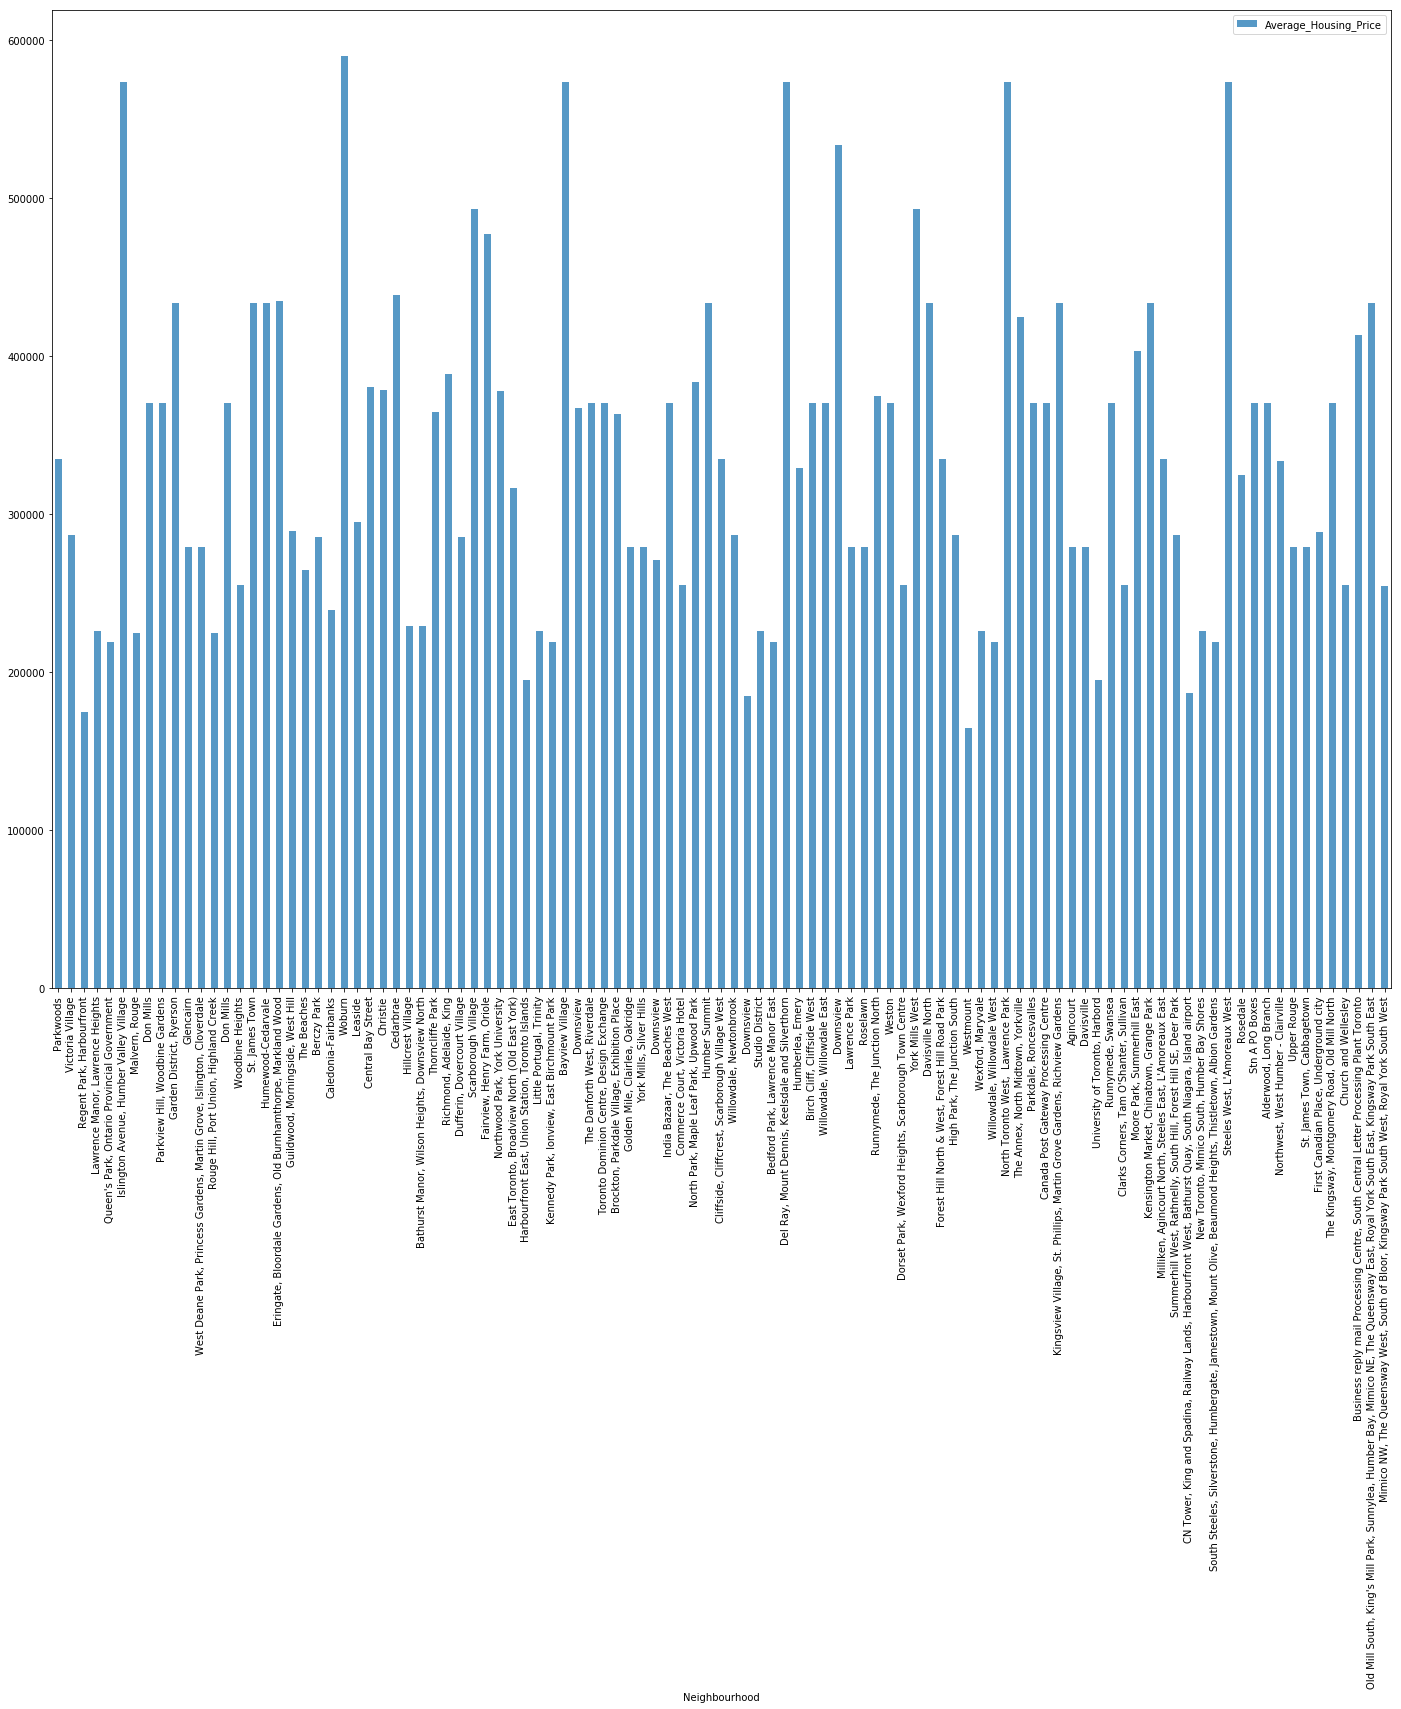

In [43]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

#### Thank You ! 
#### Hope you find it useful . I am still learning.
### Have a nice day